# Traffic light detection
## Phase 3: Detect where the traffic light is in the world.
### Members of the team: Avigail Wilk, Hadass Wittow and Nechama Verbov
### Credits:
* https://stackoverflow.com/questions/

In [1]:
import sys
import os
import pickle
import numpy as np
import math
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

### Load data for the sequence from pickle

In [2]:
with open('data.pkl', 'rb') as pklfile:
    data = pickle.load(pklfile, fix_imports=True, encoding="latin1")
    
focal_length = data['flx']
pp = data['principle_point']

EM = data['egomotion_18-19']

points_18 = data['points_18'] #previous
points_19 = data['points_19'] #current

foe = EM[:3, 3] / EM[2, 3] # t is in meters divinding it cancels the units
foe[:2] *= focal_length # to get in pixels- projection

Tz = EM[2, 3]

### Preview of the 'previous' image

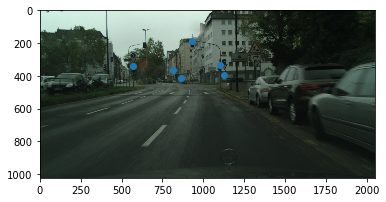

In [3]:
with open('dusseldorf_000049_000018_leftImg8bit.png', 'rb') as imgfile:
    img1 = imread(imgfile)

plt.figure('frame 18')
plt.imshow(img1)
plt.scatter(points_18[0][:, 0], points_18[0][:, 1])
plt.show()

### Preview of the 'current' image

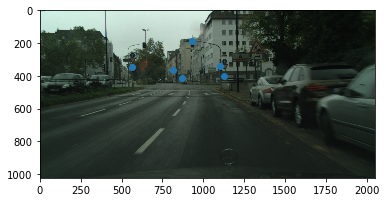

In [4]:
with open('dusseldorf_000049_000019_leftImg8bit.png', 'rb') as imgfile:
    img2 = imread(imgfile)

plt.figure('frame 19')
plt.imshow(img2)
plt.scatter(points_19[0][:, 0], points_19[0][:, 1])
plt.show()

### Rotating pixel from 'previous' image

In [5]:
def rotate_pixel(pixel):
    vec = np.array([[pixel[0] - pp[0]], [pixel[1] - pp[1]], [focal_length]])
    R = EM[:3, :3]
    rotated = (R @ vec).reshape(3,)
    
    return (rotated * (focal_length / rotated[2]))

### Distance from epipolar line

In [6]:
def point_from_epipolar(cur, foe, prev):
    m = (foe[1] - cur[1]) / (foe[0] - cur[0])
    n = (cur[1] * foe[0] - cur[0] * foe[1] ) / (foe[0] - cur[0])

    numerator = m * prev[0] + n - prev[1]
    denominator= math.sqrt(m * m + 1)
    
    return abs(numerator / denominator)

### SFM calculation

In [7]:
def Z_from_tracking(prev, cur, Tz, foe):
    
    numerator = Tz * (foe[1] - prev[1])
    denominator = cur[1] - prev[1]

    return numerator / denominator

### Iterarting over traffic lights in current image

In [8]:
def match_current_traffic_lights_to_previous():
    distances = []
    
    for point1 in points_19[0]:
        possible_matches= []
        
        # substracting the principle point to have the point in sfm coordinate system
        cur_point = np.ones(3)
        cur_point[0] = point1[0] - pp[0]
        cur_point[1] = point1[1] - pp[1]
        
        for point2 in points_18[0]:
            
            pre_point = rotate_pixel(point2)
            
            # sending the current point and the previoud point and getting their distance relative to the epipolar line
            epipolar_distance = point_from_epipolar(cur_point, foe, pre_point)

            possible_matches.append(epipolar_distance)
            
        min_idx = np.argmin(possible_matches)
        point = points_18[0][min_idx]
        matching_prev_point = rotate_pixel(point)
        point_to_match = cur_point
        
        Z = Z_from_tracking(matching_prev_point, point_to_match, Tz, foe)
        distances.append(Z)
        
    return distances
        
match_current_traffic_lights_to_previous()

[31.617296212730484,
 54.09820223852875,
 36.143995760196745,
 303.98878997250415,
 118.02530009547422,
 37.55624454937361]

### Calculating 3D position of each light

In [9]:
def calculate_3d_position():
    distances = match_current_traffic_lights_to_previous()    
    positions = []
    
    for idx, point in enumerate(points_19[0]):
        c = distances[idx]
        s = c / focal_length
        
        positions.append(np.array([[point[0] - pp[0]], [point[1] - pp[1]], [focal_length]]).reshape(3,) * s)
        
    return positions

calculate_3d_position()

[array([-7.41555331, -2.37609702, 31.61729621]),
 array([-3.94234659, -7.76944323, 54.09820224]),
 array([ 0.11207634, -2.81207842, 36.14399576]),
 array([-37.93027083, -19.62268475, 303.98878997]),
 array([-11.989632  ,  -5.22047908, 118.0253001 ]),
 array([ 0.48971024, -1.89343012, 37.55624455])]